In [1]:
import time
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd

## Data preprocessing

In [2]:
df = pd.read_csv('/home/work/DLmath/Seulbin/coin/data/KRW-XRP-merged.csv', index_col=0)

In [3]:
df = df.drop(['open', 'high', 'low', 'value'], axis=1)

In [4]:
df['close']= df['close']*(1/10000) #단위가 만원이기때문에 scale조정해주기
df['diff'] = df['close'].diff()
df['cash'] = np.zeros(df.shape[0])
df['coin'] = np.zeros(df.shape[0])
df['action'] = np.zeros(df.shape[0])

In [5]:
df['diff_100']  = df['close'].diff(periods=10)

df['volume_SMA100'] = df['volume'].rolling(10).mean()

df = df[['close', 'diff', 'volume', 'cash', 'coin', 'action', 'diff_100', 'volume_SMA100']]

df = df[10:]

In [6]:
df.head()

,close,diff,volume,cash,coin,action,diff_100,volume_SMA100
2017-09-25 23:40:00,0.0203,0.0000,0.0004,0.0,0.0,0.0,0.0003,0.00037
2017-09-25 23:50:00,0.0204,0.0001,0.0003,0.0,0.0,0.0,0.0004,0.00036
2017-09-26 00:00:00,0.0202,-0.0002,0.0004,0.0,0.0,0.0,0.0002,0.00037
2017-09-26 00:10:00,0.0202,0.0000,0.0004,0.0,0.0,0.0,0.0002,0.00037
2017-09-26 00:30:00,0.0203,0.0001,0.0003,0.0,0.0,0.0,0.0003,0.00036


In [7]:
# 결측치 확인
print(df.isnull().values.any())
print(df.isna().values.any())

False
False


In [8]:
data_array = df.to_numpy()
data_array.shape

(357872, 8)

## Environment

In [9]:
class coin_env:
    def __init__(self, df, start_index, action_space=np.array([-5,-1,0,1,5]),fee=0.001 , eps= 0.001):
        self.df = df
        self.action_space = action_space   # -5,-1: sell, 0: hold, 1,5:buy
        self.action_size  = action_space.shape[0]
        self.array = self.df.to_numpy(dtype=float)
        self.start_index = start_index
        
        self.close    = self.array[:,0]   # 'close'
        self.state1   = self.array[:,1:6] # 'diff', 'volume', 'cash', 'coin', 'action'
        self.state10  = self.array[:,6:8] # 'diff_100', 'volume_SMA100'
        self.reward   = np.zeros(self.close.shape)
        
        self.fee = fee
        self.eps = eps
        
        self.max_episodes = self.array[start_index:,:].shape[0] // 1440
        print('Possible number of episodes:', self.max_episodes)
        
    def reset(self, n, init=1000, cash_ratio=0.5): 
        
        # n번째 날 시작 시간 Index 
        day_index = 144 * n + self.start_index
        
        self.state1[day_index][2] = init * cash_ratio
        self.state1[day_index][3] = init * (1-cash_ratio)
        
        return day_index
    
    
    def step(self, state_index, action):

        done = False
        
        # done = True when the 'next' state time == 8:59
        # done : 현재 자산이 없어지는 경우에도 done을 만들어야 하지 않나?
        if (state_index-self.start_index) % 144 == 143:
            done = True
            
        # Bring the numpy array
        X = self.state1.copy()
        
        # current_state : [diff, volume, cash, coin, previous action]
        current_state = X[state_index]
        
        # current_action : -5,-1, 0, 1, 5
        # action_space = np.array([-5,-1,0,1,5])
        # 10% 확률로 거래 미체결 (current_action = 0 -> hold)
        current_action = self.action_space[action] * (np.random.rand()>0.1)
        
        next_state = X[state_index+1]
        
        # Compute Reward
        if current_state[2] - current_action - abs(current_action)*self.fee >= 0 and current_state[3] + current_action  >= 0:
            next_state[2] = current_state[2] - current_action - abs(current_action)*self.fee
            next_state[3] = ( current_state[3] + current_action ) * (self.close[state_index+1]/self.close[state_index])
            next_state[4] = current_action
            
        else:
            next_state[2] = current_state[2]
            next_state[3] = current_state[3] * (self.close[state_index+1]/self.close[state_index])
            next_state[4] = 0
        
        # If my asset is too low
        if sum(next_state[2:4]) < 500:
            done = True

        reward = sum(next_state[2:4] - current_state[2:4]) - eps*abs(current_action)
        
        self.reward[state_index+1] = reward
        
        self.state1[state_index+1] = next_state
        
        # Return (Next state_index, reward, whether the next state is the last time)
        return state_index+1, reward, done

## Model

input_shape_10   = (100,5)     # 10분봉 100개, feature 5개 (diff, volume, cash, coin, prev_action)\
input_shape_100  = (100,2)     # 100분봉 100개, feature 2개 (diff_100, volume SMA 100)\

In [10]:
class DQN(nn.Module):
    def __init__(self, action_size=5):
        super(DQN, self).__init__()
        self.action_size= action_size
        
        self.relu = torch.tanh
        self.maxpooling = nn.MaxPool1d(kernel_size=2)
        self.flatten = torch.flatten
        
        self.net_x_1 = nn.Conv1d(in_channels=5,  out_channels=10, kernel_size=3, stride=2)
        self.net_x_2 = nn.Conv1d(in_channels=10, out_channels=20, kernel_size=7,  stride=2)
        
        self.net_y_1 = nn.Conv1d(in_channels=2,  out_channels=10, kernel_size=3, stride=2)
        self.net_y_2 = nn.Conv1d(in_channels=10, out_channels=20, kernel_size=7,  stride=2)

        self.linear_1 = nn.Linear(880, 200)
        self.linear_2 = nn.Linear(200, 5)
        
    def forward(self, d):
        
        ### input_shape_10
        x = self.relu(self.net_x_1(d[0]))
        #print(f'x shape : {x.shape}')
        #print(f'x layer1 : {x}')
        x = self.relu(self.net_x_2(x))
        #print(f'x layer2 : {x}')
        x = self.flatten(x, start_dim=1)
        #print(f'x layer3 : {x}')

        ### input_shape_100
        y = self.relu(self.net_y_1(d[1]))
        y = self.relu(self.net_y_2(y))
        y = self.flatten(y, start_dim=1)
        
    
        ###
        q = torch.cat((x,y), dim= 1) 
        #print(f'shape : {q.shape}')
        #print(f'layer1 : {q}')
        q = self.relu(self.linear_1(q))
        #print(f'layer2 : {q}')
        q = self.linear_2(q)
        #print(f'layer3 : {q}')

        return q

## Utils

In [11]:
from collections import deque

class ReplayBuffer():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def store(self, state1, state10, action, reward, next_state1, next_state10, done):
        self.buffer.append([state1, state10, action, reward, next_state1, next_state10, done])

    def replay_buffer_sampling(self, batch_size):
        experience_samples = random.sample(self.buffer, batch_size)
        state1_arr, state10_arr, action_arr, reward_arr, next_state1_arr, next_state10_arr, done_arr = map(np.asarray, zip(*experience_samples))
        return state1_arr, state10_arr, action_arr, reward_arr, next_state1_arr, next_state10_arr, done_arr

    def size(self):
        return len(self.buffer)

In [12]:
def update_target(behavior, target):
    target.load_state_dict(behavior.state_dict())

###### 수정 필요 ############
def soft_update_target(behavior, target, TAU):
    for t, e in zip(target.trainable_variables, behavior.trainable_variables):
        t.assign(t * (1 - TAU) + e * TAU)

In [13]:
def update_Q(behavior_net, target_net, optimizer, buffer, batch_size, gamma, device):

    behavior_net = behavior_net.to(device)
    target_net   = target_net.to(device)
    
    state1_arr, state10_arr, action_arr, reward_arr, next_state1_arr, next_state10_arr, done_arr = buffer.replay_buffer_sampling(batch_size)
    
    state1_arr   = torch.FloatTensor(state1_arr).to(device)
    state10_arr  = torch.FloatTensor(state10_arr).to(device)
    action_arr   = torch.LongTensor(action_arr).to(device)
    next_state1_arr = torch.FloatTensor(next_state1_arr).to(device)
    next_state10_arr = torch.FloatTensor(next_state10_arr).to(device)
    reward_arr = torch.FloatTensor(reward_arr).to(device)
    done_arr =torch.FloatTensor(done_arr).to(device)
    
    predicts = torch.sum(behavior_net([state1_arr, state10_arr])*action_arr, dim=1)
    next_q =target_net([next_state1_arr, next_state10_arr])
    next_q_values = torch.max(next_q, dim=1)[0]
    targets = reward_arr + gamma*next_q_values   # *(1-done_arr) 실제로 끝나는 지점 X
    td = targets.detach() - predicts
    loss = torch.mean(td**2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [14]:
def linear_schedule(episode, max_episode, initial, final):
    start, end = initial, final
    if episode < max_episode:
        return (start*(max_episode-episode) + end*episode) / max_episode
    else:
        return end

In [15]:
def sigmoidal_decay(episode, start_value, end_value):
    start_value=1
    end_value=1e-2
    start=0
    end=900
    middle = 300 
    s = lambda x: 1 / (1 + np.exp(-x))
    
    return s(5* (-episode + middle) / np.abs(end - start)) * np.abs(start_value - end_value) + end_value

In [16]:
def get_action(behavior_net, state, epsilon):
    behavior_net = behavior_net.to('cpu')
    action_logits = behavior_net(state)    # input shape should be (batch, state_dim)
    num_actions = action_logits.shape[1]

    should_explore = np.random.rand()
    if should_explore < epsilon:
        action = np.random.choice(num_actions)
    else:
        action = torch.argmax(action_logits, dim=1)[0]
    return action

In [17]:
def plot_save(rewards, title:str, save_path=None, y_label='Total Rewards' ):  
    
    high= np.max(rewards , axis= 0)
    low= np.min(rewards , axis= 0)
    mean= np.mean(rewards , axis= 0)
    
    plt.figure(figsize=[4,2], dpi=300)
    plt.title(title , fontsize=9)
    plt.xlabel('Episodes', fontsize=7)
    plt.ylabel(y_label, fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.grid(linewidth=.1)

    x= np.arange(1, len(rewards[0])+1)
    plt.plot(x, high, 'b-', linewidth=.1, alpha=0.2)
    plt.plot(x, low, 'b-', linewidth=.1, alpha=0.2)
    plt.plot(x, mean, 'b-', linewidth=.2)
    if y_label != 'Total Rewards':
        base= [100 for i in range(len(rewards[0]))]
        plt.plot(x, base, 'r-', linewidth=.2)
    
    if save_path!=None:
        plt.savefig(save_path, format='png')
        
    plt.show()

In [18]:
def trade_log(chart, action, title:str, save_path=None ):  
    
    buy5= np.where(action==5)[0]
    buy1= np.where(action==1)[0]
    sell5= np.where(action==-5)[0]
    sell1= np.where(action==-1)[0]
    
    plt.figure(figsize=[4,2], dpi=300)
    plt.title(title , fontsize=9)
    plt.xlabel('Time', fontsize=7)
    plt.ylabel('Price', fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.grid(linewidth=.1)

    x= np.arange(1, len(chart)+1)
    plt.plot(x, chart, 'k-', linewidth=.05, alpha=0.9)
    plt.plot(buy5, chart[buy5],'r^', markersize=0.05, label='Buy Signal (5)')
    plt.plot(buy1, chart[buy1],'rs', markersize=0.05, label='Buy Signal (1)')
    plt.plot(sell5, chart[sell5],'bs', markersize=0.05, label='Sell Signal (5)')
    plt.plot(sell1, chart[sell1],'b^', markersize=0.05, label='Buy Signal (1)')
    
    if save_path!=None:
        plt.savefig(save_path, format='png')
        
    plt.show()

## Training

In [19]:
max_episode = 100
buffer_size = 60000
batch_size  = 64
initial_epsilon = 1.0
final_epsilon   = 0.05
gamma =1.0
replay_period =(1,20)
plot_period   = 10

save_folder = '/home/work/DLmath/Seulbin/coin/graph/2024-09-16/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


 ################ 
 lr : 0.0001  eps : 0.01 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -8.0493, episode length : 144
   cash: 528.733, coin: 465.888, total: 994.621
   sell5: 15, sell1: 23, hold: 42, buy1: 39, buy5: 25
   buffer size:  1440, epsilon: 0.8290
   time: 0.03 (min)


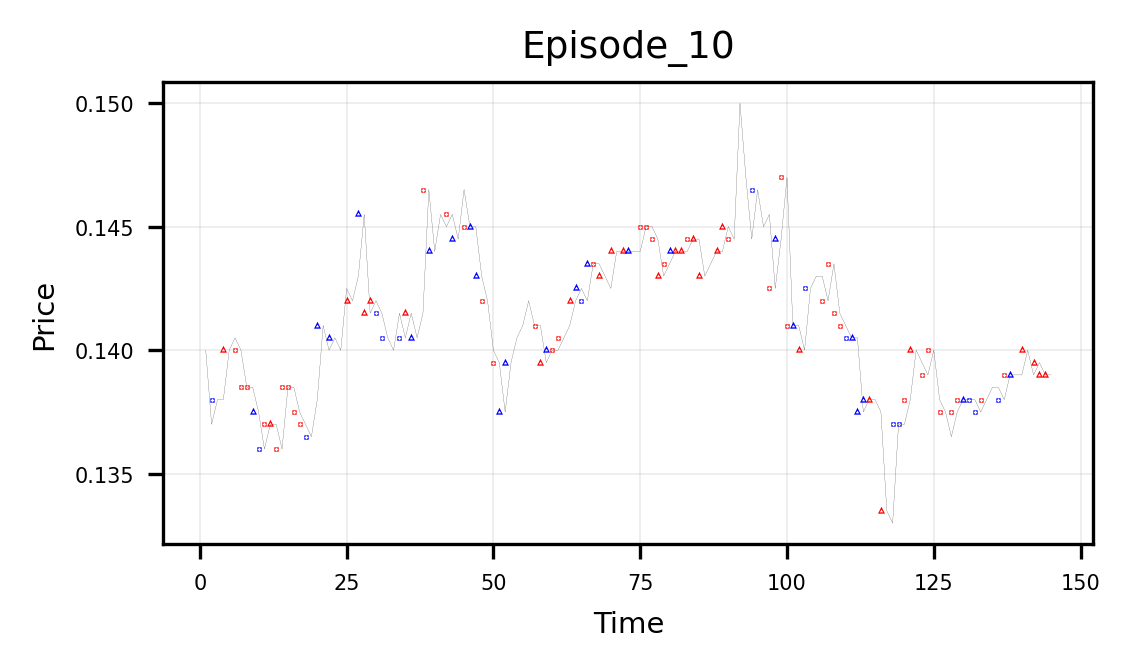

[Episode:  20] total reward: 63.8469, episode length : 144
   cash: 539.724, coin: 526.883, total: 1066.607
   sell5: 17, sell1: 22, hold: 36, buy1: 43, buy5: 26
   buffer size:  2880, epsilon: 0.6390
   time: 0.03 (min)


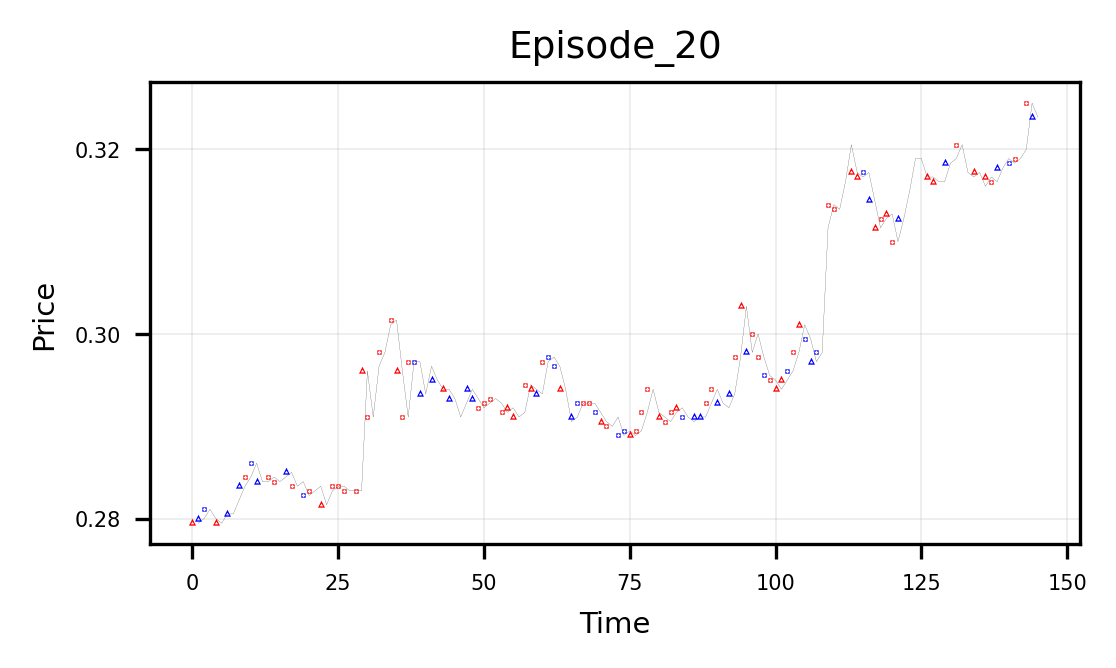

[Episode:  30] total reward: 23.7714, episode length : 144
   cash: 572.699, coin: 454.082, total: 1026.781
   sell5: 23, sell1: 22, hold: 32, buy1: 43, buy5: 24
   buffer size:  4320, epsilon: 0.4490
   time: 0.03 (min)


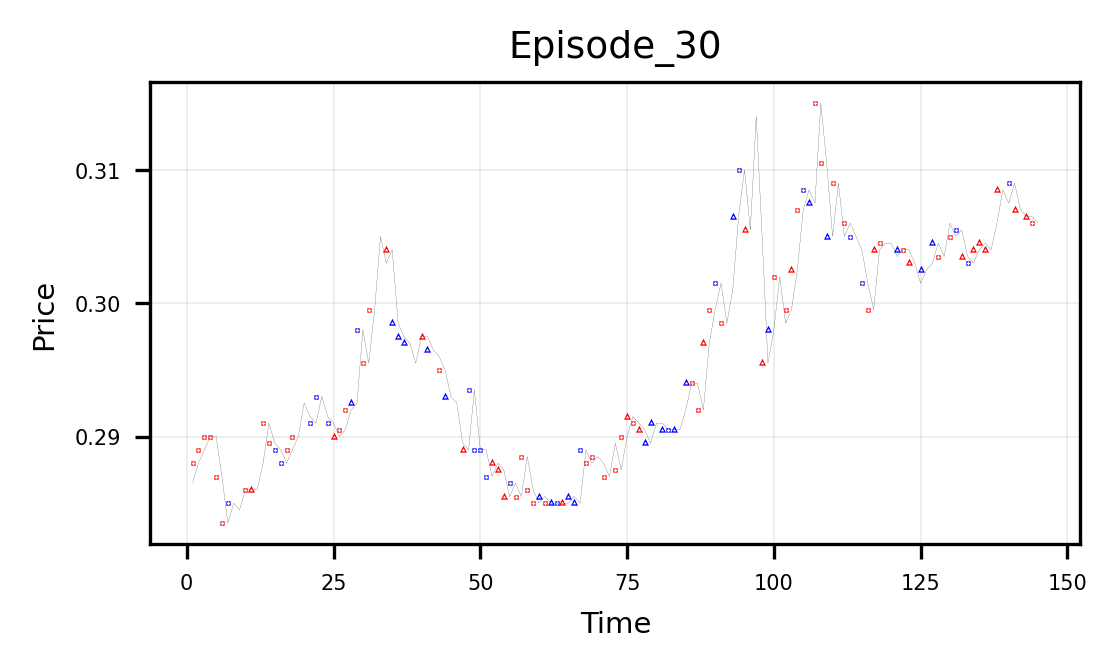

[Episode:  40] total reward: -29.5890, episode length : 144
   cash: 564.747, coin: 408.194, total: 972.941
   sell5: 14, sell1: 43, hold: 35, buy1: 29, buy5: 23
   buffer size:  5760, epsilon: 0.2590
   time: 0.03 (min)


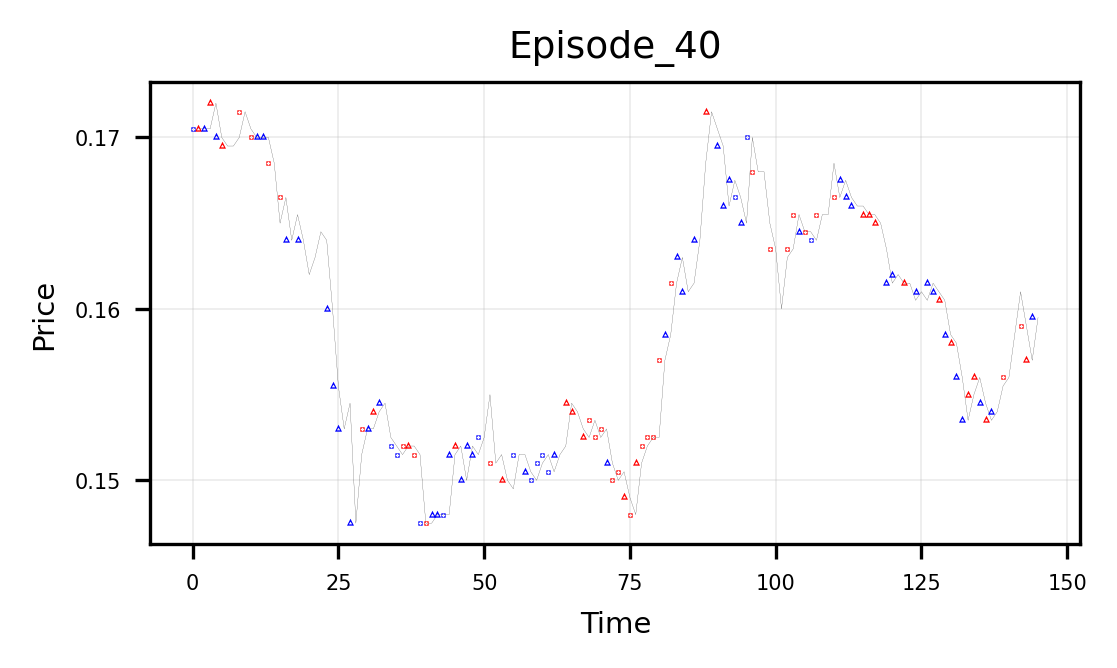

[Episode:  50] total reward: -125.8593, episode length : 144
   cash: 625.690, coin: 251.551, total: 877.241
   sell5: 29, sell1: 28, hold: 26, buy1: 42, buy5: 19
   buffer size:  7200, epsilon: 0.0690
   time: 0.03 (min)


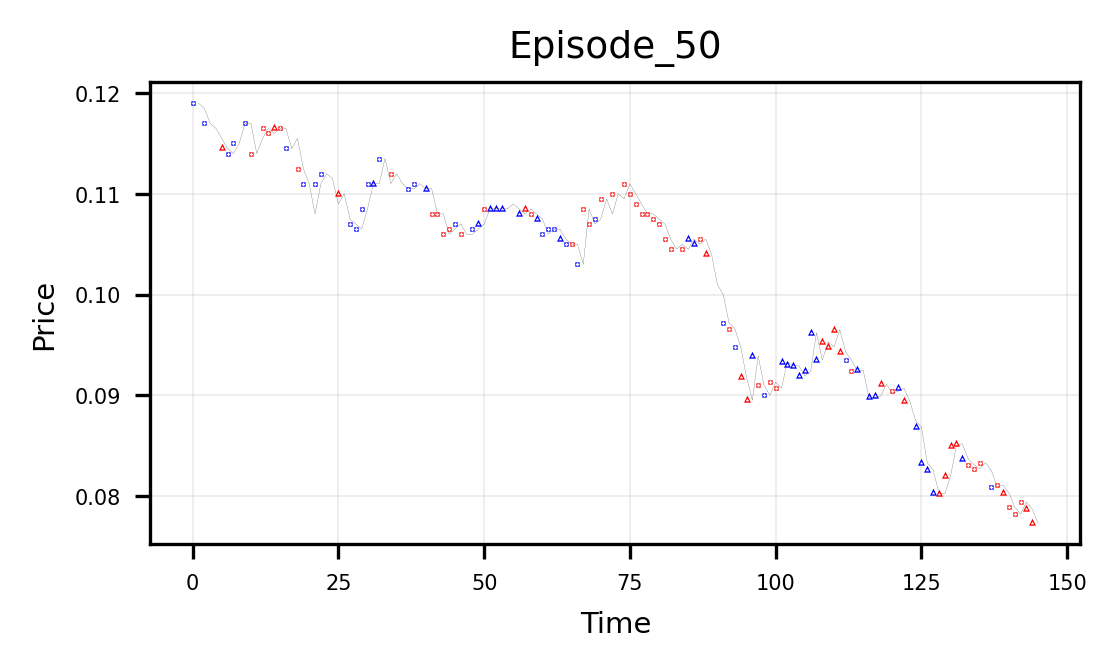

[Episode:  60] total reward: 49.2548, episode length : 144
   cash: 507.780, coin: 543.675, total: 1051.455
   sell5: 7, sell1: 29, hold: 33, buy1: 56, buy5: 19
   buffer size:  8640, epsilon: 0.0500
   time: 0.03 (min)


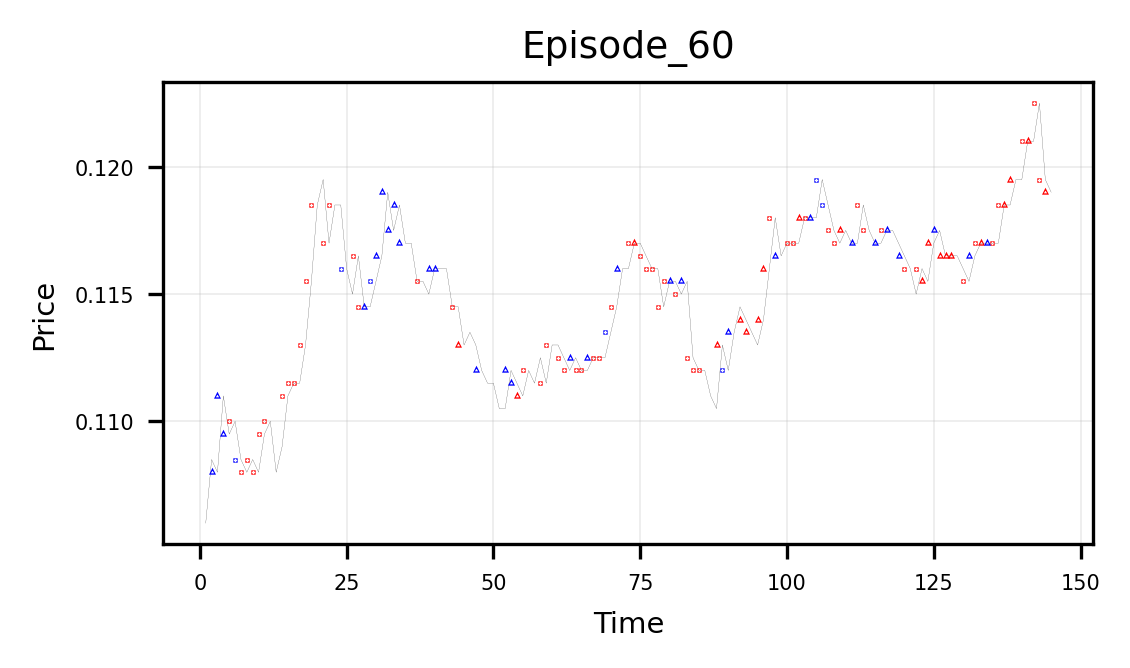

[Episode:  70] total reward: -37.9571, episode length : 144
   cash: 529.676, coin: 435.607, total: 965.283
   sell5: 23, sell1: 12, hold: 40, buy1: 37, buy5: 32
   buffer size: 10080, epsilon: 0.0500
   time: 0.03 (min)


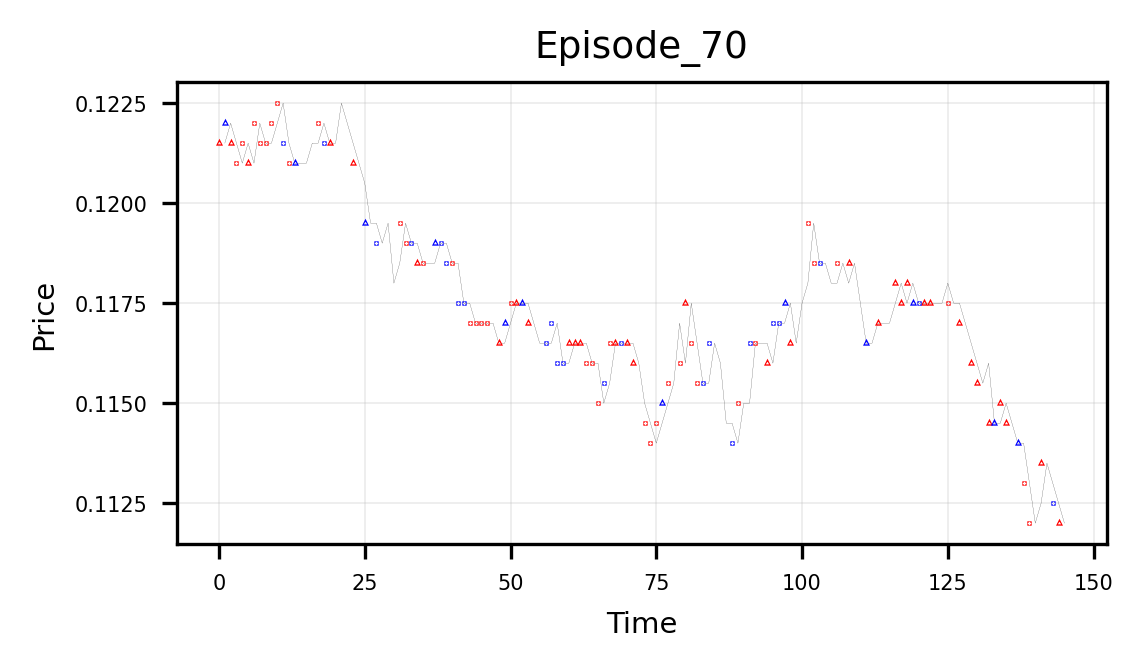

[Episode:  80] total reward: -1.8456, episode length : 144
   cash: 515.680, coin: 485.674, total: 1001.354
   sell5: 18, sell1: 27, hold: 33, buy1: 32, buy5: 34
   buffer size: 11520, epsilon: 0.0500
   time: 0.03 (min)


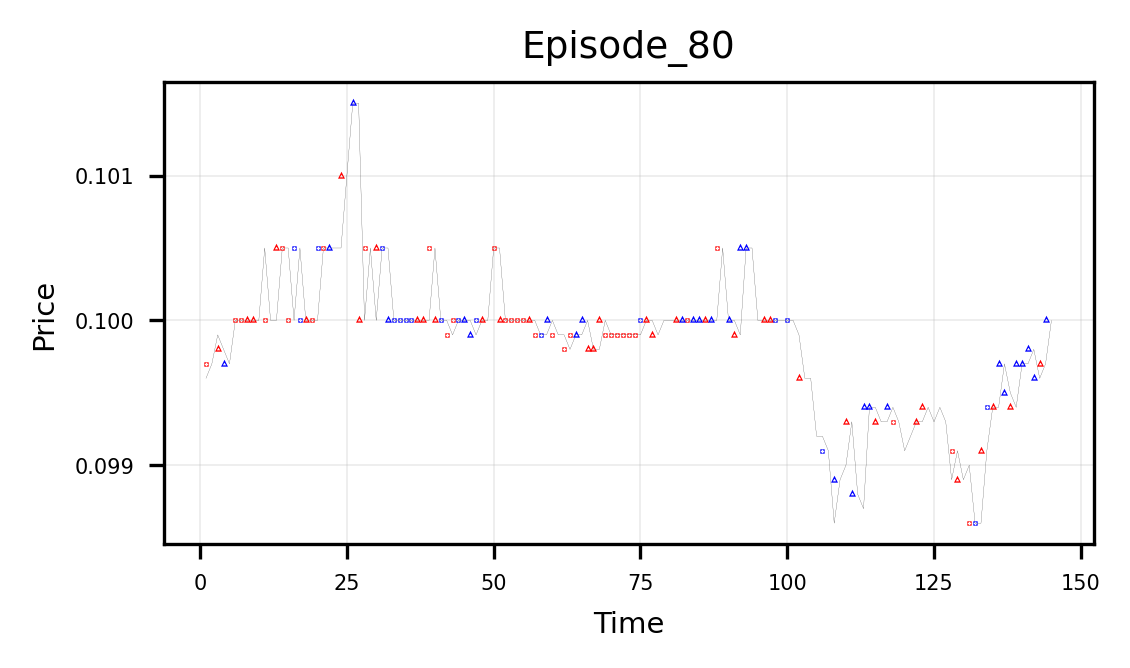

[Episode:  90] total reward: -13.6292, episode length : 144
   cash: 593.618, coin: 396.573, total: 990.191
   sell5: 32, sell1: 28, hold: 25, buy1: 25, buy5: 34
   buffer size: 12960, epsilon: 0.0500
   time: 0.03 (min)


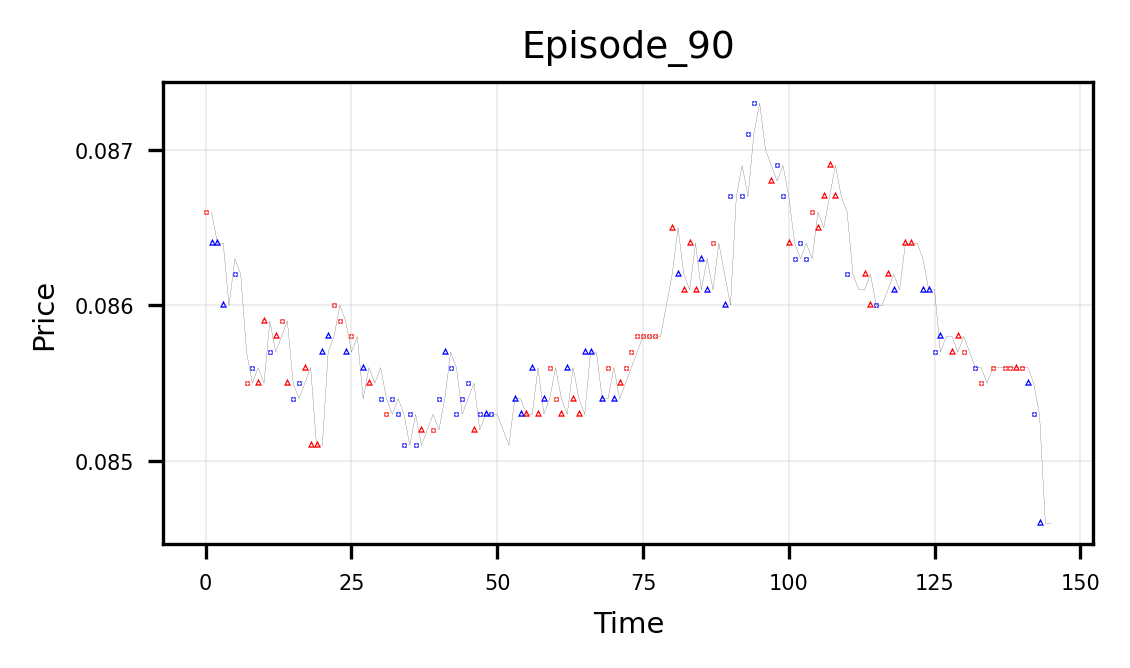

[Episode: 100] total reward: 1.4358, episode length : 144
   cash: 633.660, coin: 371.176, total: 1004.836
   sell5: 32, sell1: 22, hold: 41, buy1: 23, buy5: 26
   buffer size: 14400, epsilon: 0.0500
   time: 0.03 (min)


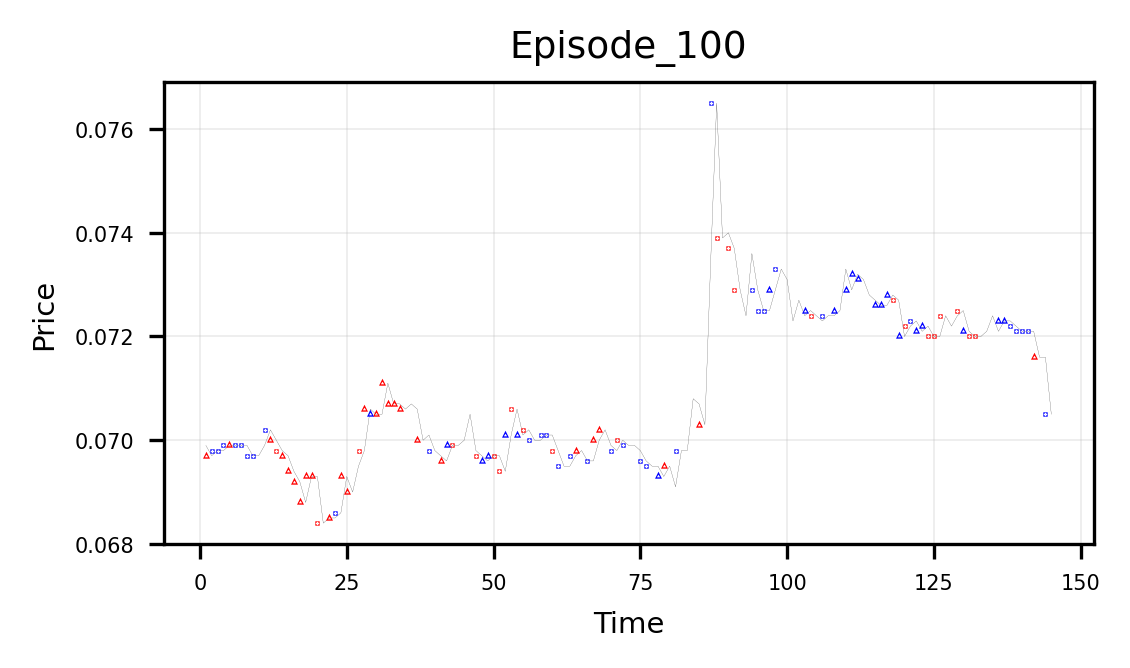

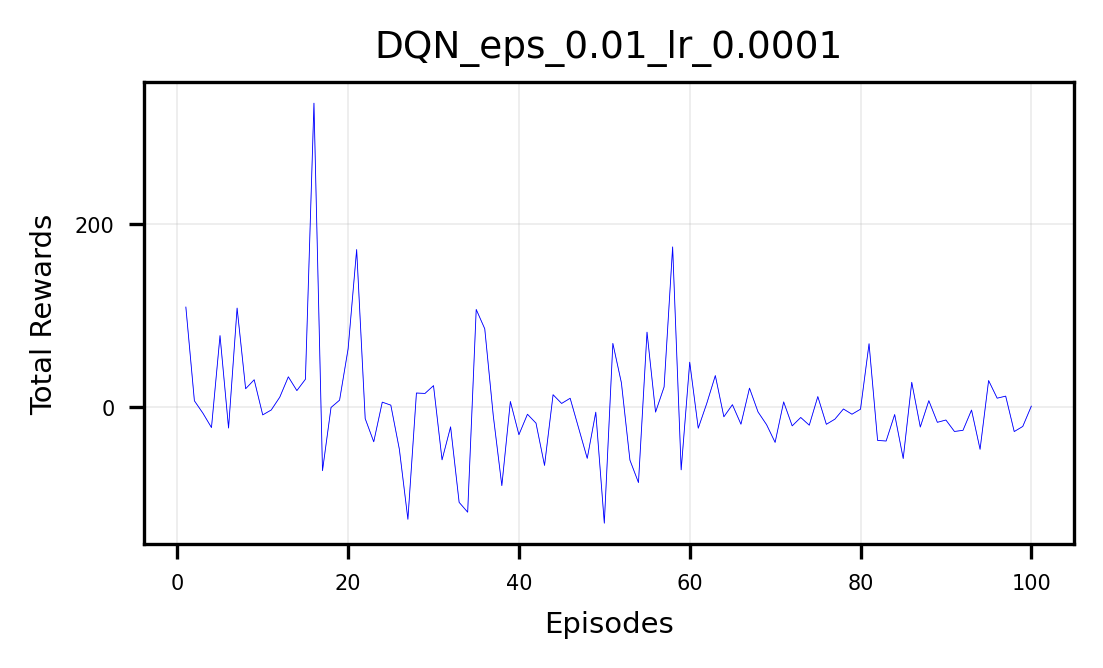

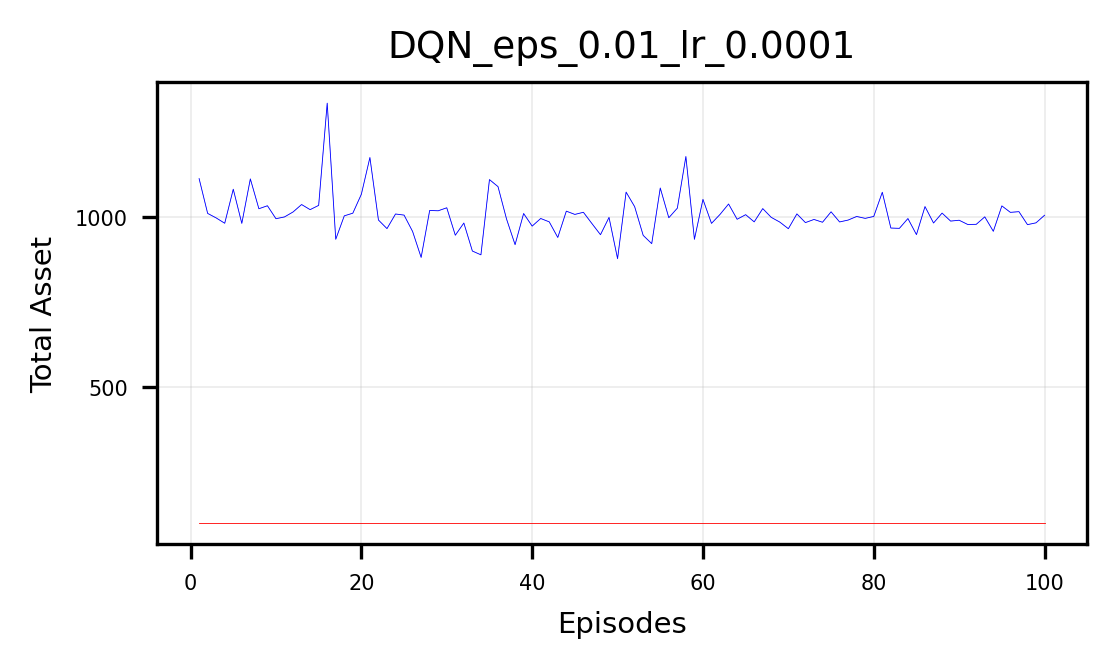

 ################ 
 lr : 1e-05  eps : 0.01 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -9.2124, episode length : 144
   cash: 447.678, coin: 546.330, total: 994.008
   sell5: 13, sell1: 20, hold: 39, buy1: 32, buy5: 40
   buffer size:  1440, epsilon: 0.8290
   time: 0.03 (min)


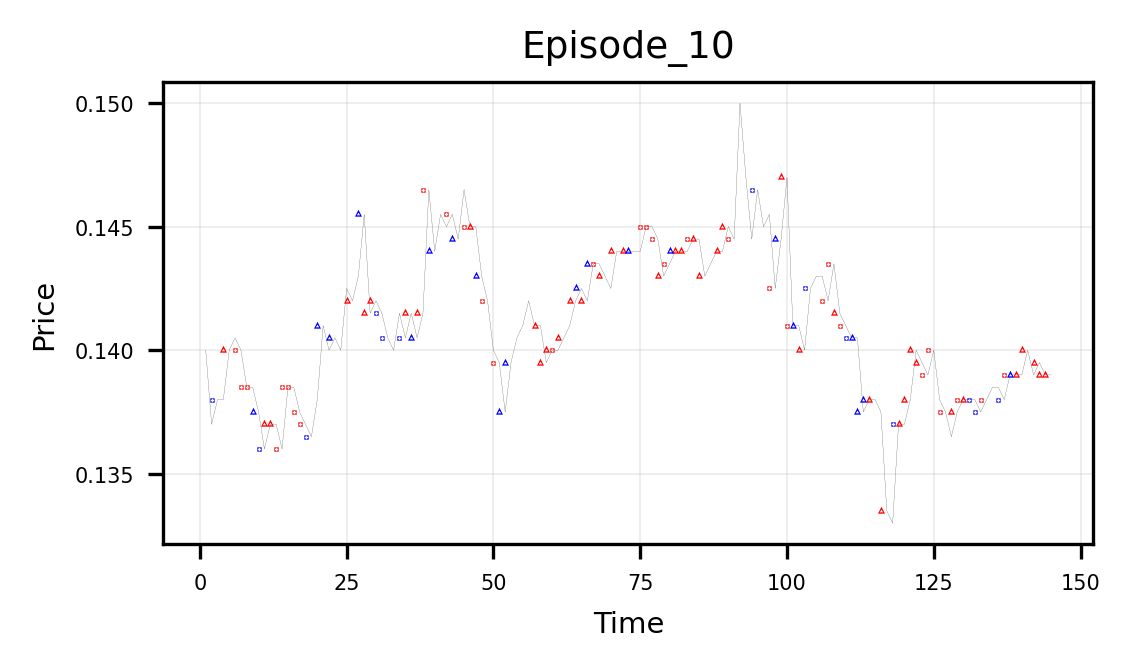

In [ ]:
#reward_scale = [2,4,8,16,32,64,128,256]

eps_list = [0.01, 0.001, 0.005]
lr_list  = [1e-4, 1e-5, 1e-6]

for eps in eps_list:
    for lr in lr_list:    
        print(f' ################ \n lr : {lr}  eps : {eps} \n ################')
        seed = 2024
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        env = coin_env(df, start_index=10594, eps= eps)

        reward_list = []
        asset_list  = []
        action_num  = env.action_size
        one_hot_action = np.eye(action_num)

        replay_buffer = ReplayBuffer(capacity=buffer_size)

        behavior_Q = DQN(action_size=5)
        target_Q   = DQN(action_size=5)

        update_target(behavior_Q, target_Q)
        optimizer = torch.optim.Adam(behavior_Q.parameters(), lr=lr)

        for episode in range(max_episode):
            start = time.time()
            done = False

            episode_reward = 0
            episode_length = 0

            epsilon = linear_schedule(episode, max_episode//2, initial_epsilon, final_epsilon)
            #lr      = sigmoidal_decay(episode, start_value=initial_lr, end_value=final_lr)
            #optimizer.learning_rate = lr

            state_index = env.reset(n=episode, init=1000, cash_ratio=0.6)
            start_index = state_index
            end_index   = state_index 
            while not done:

                state_1   = env.state1[state_index-99:state_index+1]
                state_10  = env.state10[state_index-990:state_index+1:10, :]


                state = [torch.FloatTensor(state_1.T.reshape(1,5,100)), torch.FloatTensor(state_10.T.reshape(1,2,100))]
                action = get_action(behavior_Q, state, epsilon)
                next_state_index, reward, done = env.step(state_index, action)
                #reward = scale*reward
                episode_reward += reward
                episode_length += 1

                next_state_1   = env.state1[next_state_index-99:next_state_index+1]
                next_state_10  = env.state10[next_state_index-990:next_state_index+1:10, :]

                replay_buffer.store(state_1.T, state_10.T, one_hot_action[action], reward, next_state_1.T, next_state_10.T, done)

                if replay_buffer.size() >= batch_size and episode_length%replay_period[0] == 0:
                    update_Q(behavior_Q, target_Q, optimizer, replay_buffer, batch_size, gamma, device)

                if replay_buffer.size() >= batch_size and episode_length%replay_period[1] == 0:
                    update_target(behavior_Q, target_Q)
                    # soft_update_target(behavior_Q, target_Q, TAU=0.005)

                state_index = next_state_index
                end_index += 1

            reward_list.append(episode_reward)
            asset_list.append(env.state1[state_index][2]+env.state1[state_index][3])
            end = time.time()

            env.state1[start_index:end_index,4]

            if episode % plot_period == plot_period-1:
                print(f'[Episode: {episode+1:3d}] total reward: {episode_reward:.4f}, episode length : {episode_length}')
                print(f'   cash: {env.state1[state_index][2]:.3f}, coin: {env.state1[state_index][3]:.3f}, total: {env.state1[state_index][2]+env.state1[state_index][3]:.3f}')
                print(f'   sell5: {list(env.state1[start_index:end_index,4]).count(-5)}, sell1: {list(env.state1[start_index:end_index,4]).count(-1)}, hold: {list(env.state1[start_index:end_index,4]).count(0)}, buy1: {list(env.state1[start_index:end_index,4]).count(1)}, buy5: {list(env.state1[start_index:end_index,4]).count(5)}')
                print(f'   buffer size: {replay_buffer.size():5d}, epsilon: {epsilon:.4f}')
                print(f'   time: {(end-start)/60:.2f} (min)')
                title = 'Episode_' + str(episode+1)
                save_path = save_folder +'log/eps_'+str(eps)+ '_lr_'+str(lr) +'_'+ title + '.png'
                # 거래기록 plot
                trade_log(np.array(env.close[start_index:end_index+1]), np.array(env.state1[start_index:end_index+1, 4]), title=title ,save_path=save_path)


        Title     = 'DQN_eps_'+str(eps)+'_lr_'+str(lr)
        save_path_reward = save_folder + Title + '.png'
        plot_save(rewards=[reward_list], title=Title, save_path=save_path_reward )

        save_path_asset = save_folder +'Asset_' + Title + '.png'
        plot_save(rewards=[asset_list], title=Title, save_path=save_path_asset, y_label='Total Asset' )